# Analysis broken down:

**Goal:** Use wine characteristics to perform regression on the final rating of a vintage on Vivino, which is determined through indevidual user ratings.

**Target variable is the feature ratings_average, which is scraped from vivino**

**Other features are also scraped from vivino, and are a result of merging different data sets**

- Preprocessing.
-- Applying filters from EDA section.
-- Removing NAs
-- Standard scaling

- Modelling
-- Establish evaluation framework related to the business case 
-- Apply different models with increasing complexity
-- Final model selection based on performance and business case application

- Interpretability
-- Decomposing the best performing model to derive actionable insights


#Helper functions.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, MaxAbsScaler 
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from google.colab import files
import matplotlib.pylab as pl
!pip install shap
import shap

shap.initjs()

RANDOM_STATE = 23


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plt.style.use('ggplot')

def actual_pred_plot(y_actual, y_pred):
  g=plt.scatter(y_actual, y_pred)
  g.axes.set_xlabel('True ratings ')
  g.axes.set_ylabel('Rating predictions ')
  g.set_facecolor('xkcd:salmon')
  plt.plot(list(range(2,6)), list(range(2,6)), color='black', linestyle='--')
  plt.savefig('download.png', dpi=400)
  files.download('download.png') 
  return g

def evaluate_predictions(y_actual, y_pred):
  d = pd.DataFrame()
  d['actuals'], d['predicted'] = y_actual, y_pred
  d['difference'] =  d['predicted'] - d['actuals'] 
  d['abs_difference'] = abs(d['difference'])
  bias = d['difference'].sum()/d.shape[0]
  extremes = len(d[d['abs_difference'] >= 0.3])/d.shape[0]*100
  r2 = r2_score(y_actual, y_pred)
  MSE = mean_squared_error(y_actual, y_pred)
  
  print('Percentage of extreme observations is: ', extremes)
  print('R2: ', r2)
  print('Bias is: ', bias)
  print('MSE: ', MSE)
  return [MSE, r2, extremes, bias]

  

class SML_Utils:

  def __init__(self, df, dep_var, test_size, manual_scalers = None, scaler='standard', scorer='explained_variance', label_encoding_excludes= None):

    #Defining options
    scalers = {'standard' : StandardScaler(),
               'minmax' : MinMaxScaler()}
    
    scorers = {'explained_variance' : explained_variance_score,
               'mse' : mean_squared_error}

    #Defining class attributes
    self.scorer = scorers[scorer]
    self.dataframe = df
    self.numeric_cols = list(self.dataframe.select_dtypes([np.number]).columns)
    self.scaler = scalers[scaler]
    self.test_size = test_size
    self.dep_var = dep_var
    self.component_reduced_df = None
    labelencoder = LabelEncoder()

    #Encoding all non-numeric columns
    self.non_numeric_cols = [x for x in self.dataframe.columns if not x in self.numeric_cols]
    self.error_features = []

    if dep_var in self.numeric_cols:
      self.numeric_cols.remove(dep_var)
    
    for col in self.non_numeric_cols:
      if col in label_encoding_excludes:
        break
      
      try:
        self.dataframe[col] = labelencoder.fit_transform(self.dataframe[col])
      except TypeError:
        self.error_features.append(col)
        self.dataframe.drop([col], axis=1, inplace=True)
    
    if manual_scalers != None:
      for col in manual_scalers:
        try:
          self.dataframe[col] = labelencoder.fit_transform(self.dataframe[col])
        except TypeError:
          self.error_features.append(col)
          self.dataframe.drop([col], axis=1, inplace=True)

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.dataframe.drop([self.dep_var], axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)

  def subset_X(self, excludes):
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

  def reduce_dimensions(self, model, n_components, transform = True):
        if model == 'PCA':
          pca = PCA(n_components=n_components)
          pca_df = self.dataframe #Create duplicate so no to interfere with original dataframe
          pca_df.loc[:, self.numeric_cols] = self.scaler.fit_transform(self.dataframe.loc[:, self.numeric_cols])
          pca_df = pca.fit_transform(self.dataframe.loc[:, self.numeric_cols])
          if transform: self.component_reduced_df = pca_df
          return pca.explained_variance_ratio_ #Revise output

        if model == 'UMAP':
          reducer = umap.UMAP(n_components=n_components)
          umap_df = self.dataframe #Create duplicate so no to interfere with original dataframe
          umap_df.loc[:, self.numeric_cols] = self.scaler.fit_transform(self.dataframe.loc[:, self.numeric_cols])
          umap_df = reducer.fit_transform(umap_df.loc[:, self.numeric_cols])
          self.component_reduced_df = umap_df
          return umap_df.shape #Validation of shape  

        if model == 'NMF':
          nmf = NMF(n_components=n_components)
          df_nmf = nmf.fit_transform(self.dataframe.loc[:, self.numeric_cols])
          nmf = nmf.fit(self.dataframe.loc[:, self.numeric_cols])
          prediction = nmf.inverse_transform(nmf.transform(self.dataframe.loc[:, self.numeric_cols]))
          self.component_reduced_df = prediction
          return self.scorer(self.dataframe.loc[:, self.numeric_cols], prediction)


  def scale_data(self, excludes = None):
    scaling_df = self.dataframe.loc[:, self.numeric_cols]

    if excludes != None: 
      for e in excludes: 
        del scaling_df[e]
    
    scaled_values_df = self.scaler.fit_transform(scaling_df) 
    names = self.dataframe.columns      
    scaled_names = scaling_df.columns 
    scaled_df = self.dataframe                               
    scaled_df.loc[:,scaled_names] = scaled_values_df
    
    scaled_df.columns = names
    self.df = scaled_df 
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.dataframe.drop([self.dep_var], axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    return scaled_df

  def linear_regression(self, excludes = None):
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    model = LinearRegression()
    res = model.fit(X_train, y_train)
    print('Linear regression train MSE: ', mean_squared_error(res.predict(X_train), y_train))
    print('Linear regression test MSE: ', mean_squared_error(res.predict(X_test), y_test))
    print('Linear regression train R2: ', r2_score(res.predict(X_train), y_train))
    print('Linear regression test R2: ', r2_score(res.predict(X_test), y_test))
    return res

  def logistic_regression(self, excludes = None):
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    model = LogisticRegression()
    res = model.fit(X_train, y_train)
    print('Logistic regression train-score: ', model.score(X_train, y_train))
    print('Logistic regression test-score: ', model.score(X_test, y_test))
    return res
    
  def random_forest_classification(self, excludes = None):
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    model = RandomForestClassifier(n_estimators=50)
    res = model.fit(X_train, y_train)
    print('Random forest train-score: ', model.score(X_train, y_train))
    print('Random forest test-score: ', model.score(X_test, y_test))
    return res

  def random_forest_regression(self, excludes = None):
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test

    model = RandomForestRegressor(n_estimators=50)
    
    ##USED FOR HYPERPARAMETER TUNING. NOT USED AFTER OPTIMAL STRUCTURE FOUND
    #parameters = {'bootstrap': [True, False],
    #                  'max_depth': [3,10, 20, None],
    #                  'min_samples_split': [2, 5, 10],
    #                  'n_estimators': [50]}


    #grid = GridSearchCV(model, parameters, cv = 5, scoring='neg_mean_squared_error')
    
    #model = grid.fit(X_train, y_train).best_estimator_
    
    #scores = cross_val_score(model,X_train, y_train, cv=5)
    #print('scores: {}'.format(scores))

    res = model.fit(X_train, y_train)
    print('Random forest train MSE: ', mean_squared_error(res.predict(X_train), y_train))
    print('Random forest test MSE: ', mean_squared_error(res.predict(X_test), y_test))
    return res

  def XGBoost_regression(self, n_estimators=100, reg_lambda=1, gamma=0, max_depth=3, excludes = None):
    model = xgb.XGBRegressor(n_estimators=n_estimators, reg_lambda=reg_lambda, gamma=gamma, max_depth=max_depth)
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    
    scores = cross_val_score(model,X_train, y_train, cv=5)
    print('scores: {}'.format(scores))
    
    res = model.fit(X_train, y_train)
    print('XGBoost train MSE: ', mean_squared_error(res.predict(X_train), y_train))
    print('XGBoost regression test MSE: ', mean_squared_error(res.predict(X_test), y_test))
    return res

  def elastic_net_regression(self, alpha=1.0, l1_ratio=0.5, excludes = None):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    res = model.fit(X_train, y_train)
    print('Elastic net train MSE: ', mean_squared_error(res.predict(X_train), y_train))
    print('Elastic net test MSE: ', mean_squared_error(res.predict(X_test), y_test))
    return res

  def lasso_regression(self, excludes = None):
    model = LassoCV()
    if excludes != None: 
      excludes.append(self.dep_var)
      X_train, X_test, y_train, y_test = train_test_split(self.dataframe.drop(excludes, axis=1, inplace=False), self.dataframe[self.dep_var], test_size=self.test_size, random_state=RANDOM_STATE)
    else:
      X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    res = model.fit(X_train, y_train)
    print('Lasso regression train MSE: ', mean_squared_error(res.predict(X_train), y_train))
    print('Lasso regression test MSE: ', mean_squared_error(res.predict(X_test), y_test))
    return res

     |████████████████████████████████| 327kB 5.5MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463914 sha256=c83185e7b97e5e101d7190cb93f13d4b4b098d738c56ad026468b1cbd2e3ab10
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


Mounting drive

In [2]:
#Enable google docs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DSBA exam: Predicting wine popularity using NLP and deep learning
Authors: Andreas C. Markussen (109923), Christian Stolborg (109903) and Mathias R. Jørgensen (111284)



This paper will investigate what constitues a popular wine. The business case is as follows: 
When importing new wines for stock, importers usually visit the wineries themselves and sample the wines in question. The issue is that the popularity of the wine is diffultcult to assess for the buyer, and success largely rests on his/her ability to anticipate the tastes of the general public, rather than a structured assessment framework. In this paper we will be guiding a danish wine importer in selecting the wines that will, eventually, become the most popular- In this project we will work around the following problem statement:


##Data collection
We use the *ratings average* matric of vivino.com as our dependent variable, and furthermore use other vivino.com metrics as our preliminary features. The data is scraped through a combination of requests, Selenium and BeatifulSoup in python. The data used is scraped on 14-11-2020.

#1. Imports, init and preprocessing

In [3]:
#Imports and filtering. Update this --> Mathias is on top of this.
vintages_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/all_vintages.csv")
reviews_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/all_reviews_and_users.csv")
vintages_df.drop(columns=['average_ratings', 'net_follower_score', 'most_used_grapes', 'foods'], inplace=True)
vintages_df.dropna(inplace=True)
vintages_df = vintages_df[vintages_df['year'] != 'U.V.']
vintages_df = vintages_df[vintages_df['year'] != 'N.V.']
vintages_df['year'] = vintages_df['year'].astype(int)

vintages_df = vintages_df[vintages_df['price'] > 50]
vintages_df = vintages_df[vintages_df['price'] < 6000]
vintages_df = vintages_df[vintages_df['ratings_count']>50]
vintages_df = vintages_df[vintages_df['reviews_count']>50]
vintages_df = vintages_df[vintages_df['year']>1960]
vintages_df = vintages_df[((vintages_df['types'] == 'Red wine') | (vintages_df['types'] == 'White wine' ))]

def format_wine_structure(dataframe, series):
  x = dataframe[series].str.replace('0p', '0')
  return x.astype(float)

for i in ['bold', 'sweet', 'tannic']:
  vintages_df[i] = format_wine_structure(vintages_df, i)

#print(vintages_df.vintage_id)

del vintages_df['Unnamed: 0']
#del vintages_df['Unnamed: 0.1']
del vintages_df['top_region_pct']
del vintages_df['top_world_pct']
del vintages_df['winery_id']
del vintages_df['region']
del vintages_df['currency']
del vintages_df['median_type']
del vintages_df['price']
del vintages_df['wine_id']
del vintages_df['region_id']
del vintages_df['total_flavors']
del vintages_df['winery_name']
del vintages_df['country_name']



vintages_df

,vintage_id,year,ratings_count,ratings_average,labels_count,reviews_count,is_natural,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,users_count,regions_count,wines_count,wineries_count,median_price,bold,tannic,sweet,oaky,black fruit,red fruit,earthy,spices,ageing,yeasty,dried fruit,citrus,tree fruit,vegetal,floral,tropical,beef,lamb,veal,poultry,pork,shellfish,vegetarian,game,spicy-food,types
1,5625084,2014,1358,4.4,6279,407,False,119738,4.0,457778,47,484656.0,37.0,41242.0,4656.0,248.89,67.6680,37.1303,19.56740,0.331671,0.271820,0.137157,0.112219,0.062344,0.007481,0.014963,0.017456,0.002494,0.007481,0.009975,0.024938,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
2,2117077,2012,1118,4.2,3841,336,False,119738,4.0,457778,47,484656.0,37.0,41242.0,4656.0,206.73,67.6680,37.1303,19.56740,0.331671,0.271820,0.137157,0.112219,0.062344,0.007481,0.014963,0.017456,0.002494,0.007481,0.009975,0.024938,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
3,2223038,2013,1675,4.4,6678,532,False,119738,4.0,457778,47,484656.0,37.0,41242.0,4656.0,289.69,67.6680,37.1303,19.56740,0.331671,0.271820,0.137157,0.112219,0.062344,0.007481,0.014963,0.017456,0.002494,0.007481,0.009975,0.024938,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
4,2386146,2011,1607,4.2,5377,585,False,119738,4.0,457778,47,484656.0,37.0,41242.0,4656.0,325.00,67.6680,37.1303,19.56740,0.331671,0.271820,0.137157,0.112219,0.062344,0.007481,0.014963,0.017456,0.002494,0.007481,0.009975,0.024938,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
5,22124179,2015,726,4.4,3174,236,False,119738,4.0,457778,47,484656.0,37.0,41242.0,4656.0,255.98,67.6680,37.1303,19.56740,0.331671,0.271820,0.137157,0.112219,0.062344,0.007481,0.014963,0.017456,0.002494,0.007481,0.009975,0.024938,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77911,57244403,2015,304,4.2,5058,105,False,14350,4.2,135640,2,3975455.0,1280.0,490885.0,65178.0,575.00,64.0037,61.5952,7.01969,0.312621,0.273786,0.071845,0.176699,0.069903,0.009709,0.023301,0.025243,0.005825,0.001942,0.011650,0.017476,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Red wine
77912,26879557,2015,1914,3.5,10735,643,False,7937,3.5,47593,4,820134.0,91.0,45675.0,5410.0,105.54,61.7688,37.3811,12.49310,0.328671,0.209790,0.125874,0.132867,0.083916,0.034965,0.048951,0.013986,0.013986,0.000000,0.006993,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
77913,91412830,2016,1078,3.7,7541,357,False,7937,3.5,47593,4,820134.0,91.0,45675.0,5410.0,105.54,61.7688,37.3811,12.49310,0.328671,0.209790,0.125874,0.132867,0.083916,0.034965,0.048951,0.013986,0.013986,0.000000,0.006993,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine
77914,3176625,2012,439,3.4,1627,169,False,7937,3.5,47593,4,820134.0,91.0,45675.0,5410.0,105.54,61.7688,37.3811,12.49310,0.328671,0.209790,0.125874,0.132867,0.083916,0.034965,0.048951,0.013986,0.013986,0.000000,0.006993,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Red wine


#3. Supervised learning

Scaling data and init object


In [4]:
vintages_sml = SML_Utils(vintages_df, dep_var='ratings_average', test_size=0.1, manual_scalers=['is_natural', 'types'], label_encoding_excludes = [])
vintages_sml.scale_data(excludes= ['types', 'year', 'vintage_id'])

,vintage_id,year,ratings_count,labels_count,reviews_count,is_natural,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,users_count,regions_count,wines_count,wineries_count,median_price,bold,tannic,sweet,oaky,black fruit,red fruit,earthy,spices,ageing,yeasty,dried fruit,citrus,tree fruit,vegetal,floral,tropical,beef,lamb,veal,poultry,pork,shellfish,vegetarian,game,spicy-food,types
67638,30450329,2015,684,10785,213,0,7719,3.5,84017,15,3975455.0,1280.0,490885.0,65178.0,78.00,63.1085,54.8601,1.98433,0.197425,0.175966,0.214592,0.240343,0.068670,0.004292,0.025751,0.012876,0.008584,0.012876,0.012876,0.025751,0.000000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
59204,1238040,2010,401,1734,94,0,18091,3.8,113801,20,3395333.0,554.0,324753.0,39341.0,88.07,54.3350,21.1929,7.48953,0.142061,0.222841,0.324048,0.139276,0.077066,0.007428,0.023213,0.022284,0.004643,0.004643,0.019499,0.012999,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0
63987,1405407,2012,2270,12135,682,0,265099,3.9,2047625,113,3395333.0,554.0,324753.0,39341.0,110.00,45.5310,42.1790,4.66532,0.233142,0.134864,0.302726,0.162841,0.081062,0.004304,0.020086,0.018651,0.005739,0.005022,0.013630,0.017934,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1484,1340806,2005,609,2627,199,0,118132,4.2,558793,25,484656.0,37.0,41242.0,4656.0,1097.74,75.5613,56.1561,13.66520,0.468085,0.191489,0.069149,0.090426,0.101064,0.021277,0.010638,0.010638,0.010638,0.000000,0.005319,0.021277,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
25443,2886517,2010,474,1876,158,0,48023,3.9,257600,38,3395333.0,554.0,324753.0,39341.0,147.01,57.8365,44.0480,13.95040,0.208202,0.110410,0.324921,0.148265,0.113565,0.009464,0.018927,0.012618,0.009464,0.003155,0.006309,0.034700,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64609,15671699,2015,421,5399,196,0,24044,4.0,228023,6,3975455.0,1280.0,490885.0,65178.0,799.00,62.5740,66.1093,8.45349,0.285882,0.272941,0.089412,0.209706,0.067059,0.009706,0.015000,0.013235,0.003824,0.002941,0.012059,0.017941,0.000294,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
8688,151992211,2017,564,7110,225,0,31177,3.8,254975,91,9314284.0,353.0,223615.0,25755.0,71.87,41.5897,19.2233,5.91376,0.197970,0.074450,0.487310,0.118443,0.049069,0.005076,0.020305,0.006768,0.005076,0.006768,0.010152,0.015228,0.003384,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
71383,1279201,2007,1235,7998,394,0,34716,4.2,261112,8,3975455.0,1280.0,490885.0,65178.0,1700.00,73.9816,74.8791,9.47841,0.286717,0.243521,0.056156,0.234881,0.063715,0.011609,0.019708,0.012959,0.017549,0.019438,0.008909,0.016199,0.008639,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
41278,155136296,2016,269,2160,111,0,6162,3.6,42691,39,3395333.0,554.0,324753.0,39341.0,77.56,51.9423,34.9302,14.40410,0.280000,0.160000,0.360000,0.000000,0.080000,0.000000,0.020000,0.020000,0.060000,0.000000,0.000000,0.020000,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0


###3.2.1 Linear regression

Linear regression train MSE:  0.03315518726217856
Linear regression test MSE:  0.03530336621332255
Linear regression train R2:  0.48631834594047174
Linear regression test R2:  0.4563566381211841


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

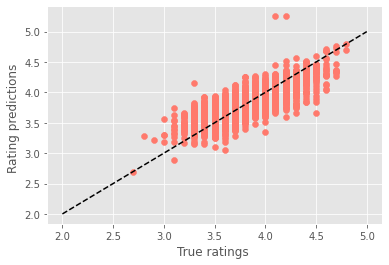

In [ ]:
lr_model = vintages_sml.linear_regression(excludes = ['ratings_average', 'vintage_id']) #ratings average acutually redundant - handled by SML obj.
lr_preds = lr_model.predict(vintages_sml.X_test)
actual_pred_plot(vintages_sml.y_test, lr_preds)

In [ ]:
evaluate_predictions(vintages_sml.y_test, lr_preds)

Bias is:  -0.0006305274949052603
Percentage of extreme observations is:  10.532994923857867
R2:  0.6330933145669921
MSE:  0.035303781288932023


[-0.0006305274949052603,
 10.532994923857867,
 0.6330933145669921,
 0.035303781288932023]

###3.2.2 Random forest

Random forest train MSE:  0.0019859949219484677
Random forest test MSE:  0.01441052622673435


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

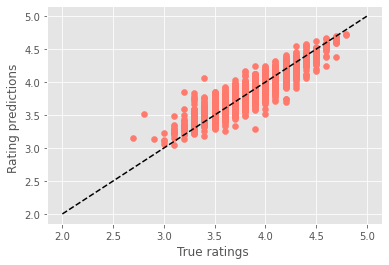

In [ ]:
rf_model = vintages_sml.random_forest_regression(excludes = ['ratings_average', 'vintage_id']) #ratings average acutually redundant - handled by SML obj.
rf_preds = rf_model.predict(vintages_sml.X_test)
actual_pred_plot(vintages_sml.y_test, rf_preds)

###3.2.3 XGBoost

[12:01:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
scores: [0.8598909  0.85387049 0.85905811 0.85607534 0.85422444]
[12:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


XGBoost train MSE:  0.005493136772835852
XGBoost regression test MSE:  0.014158892084963544


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

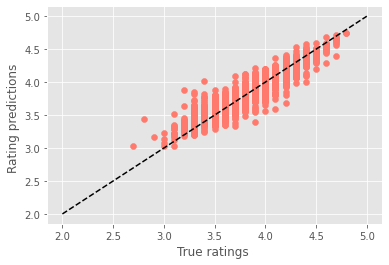

In [5]:
xgb_model = vintages_sml.XGBoost_regression(excludes = ['vintage_id'], n_estimators=100, reg_lambda=0, gamma=0, max_depth=8)
xgb_preds = xgb_model.predict(vintages_sml.X_test.drop(columns=['vintage_id'], axis=1, inplace=False))
actual_pred_plot(vintages_sml.y_test, xgb_preds)

In [9]:
import joblib
#save model
joblib.dump(xgb_model, 'xbg_wine_model.joblib')
from google.colab import files
files.download('xbg_wine_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


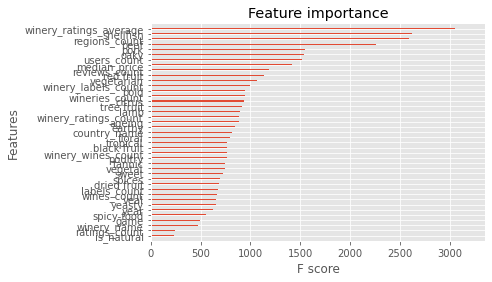

In [ ]:
#https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
xgb_d = pd.DataFrame()
xgb_d['actuals'], xgb_d['predicted'] = vintages_sml.y_test, xgb_preds
#xgb_d
xgb.plot_importance(xgb_model, importance_type='cover', show_values=False)

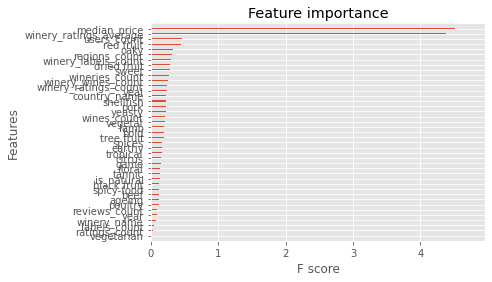

In [ ]:
xgb.plot_importance(xgb_model, importance_type='gain', show_values=False)

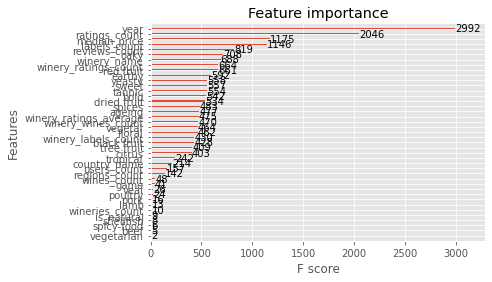

In [ ]:
xgb.plot_importance(xgb_model, importance_type='weight')

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(vintages_sml.X_train)
shap.force_plot(explainer.expected_value, shap_values[0,:], vintages_sml.X_train.iloc[0,:], show=False)
#plt.savefig('force_plot.png')

ValueError: ignored

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], vintages_sml.X_train.drop(['total_flavors'], inplace=False, axis= 1).iloc[:1000,:])


Output hidden; open in https://colab.research.google.com to view.

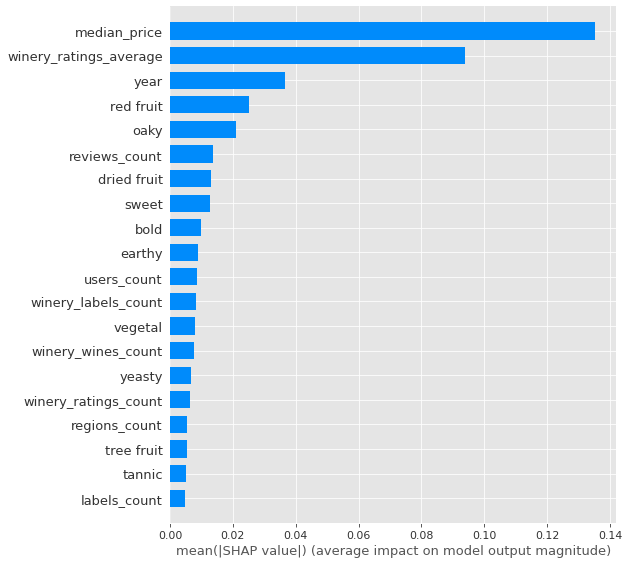

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, vintages_sml.X_train, plot_type="bar")
#plt.savefig('download.png', dpi=400)
#files.download('download.png')

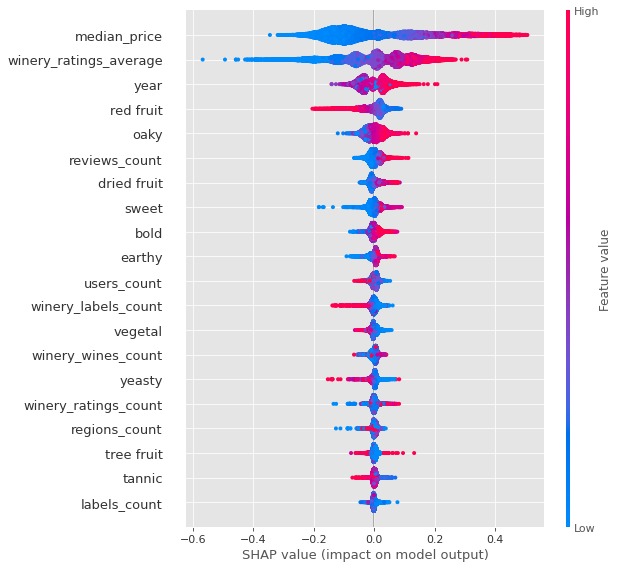

In [ ]:
shap.summary_plot(shap_values, vintages_sml.X_train)
#plt.savefig('importance_scatter_xgb.png', dpi=400, bbox_inches='tight#')
#files.download('importance_scatter_xgb.png')

In [ ]:
for name in vintages_sml.X_train.columns:
    print(name)
    shap.dependence_plot(ind = name, shap_values = shap_values, features = vintages_sml.X_train, display_features=vintages_sml.X_train)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
shap.dependence_plot(ind = 'median_price', shap_values = shap_values, features = 'winery_ratings_average', display_features='winery_ratings_average')

NameError: ignored

Elastic net train MSE:  0.09769941811052504
Elastic net test MSE:  0.09624694506960747


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

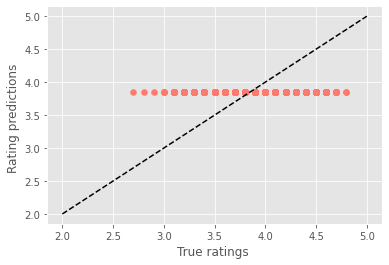

In [ ]:
el_preds = vintages_sml.elastic_net_regression(excludes = None).predict(vintages_sml.X_test)
actual_pred_plot(vintages_sml.y_test, el_preds)

In [ ]:
evaluate_predictions(vintages_sml.y_test, el_preds)

0.35153019023986765

Lasso regression train MSE:  0.03334700581603724
Lasso regression test MSE:  0.035490125928836554


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

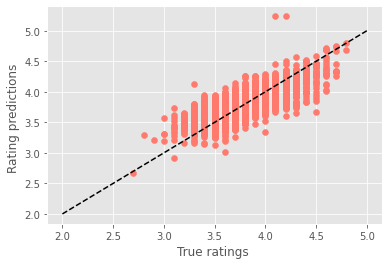

In [ ]:
l_preds = vintages_sml.lasso_regression(excludes = None).predict(vintages_sml.X_test)
actual_pred_plot(vintages_sml.y_test, l_preds)

In [ ]:
evaluate_predictions(vintages_sml.y_test, l_preds)

0.11786600496277916

### 3.2.6. Neural Network


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor

X = vintages_sml.X_train
Y = vintages_sml.y_train


def baseline_model():
	model = Sequential()
	model.add(Dense(256, input_dim=40, kernel_initializer='normal', activation='relu'))
	model.add(Dense(128, activation='relu'))
 
	model.add(Dense(1, kernel_initializer='normal'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

##VALIDATION. NOT USED IN FINAL VERSION, AS IT TAKES HOURS TO TRAIN
#estimator = KerasRegressor(build_fn=baseline_model, epochs=40, batch_size=5, verbose=1)
#kfold = KFold(n_splits=5)
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Epoch 1/60
709/709 [==============================] - 1s 1ms/step - loss: 3.5759
Epoch 2/60
709/709 [==============================] - 1s 1ms/step - loss: 0.1951
Epoch 3/60
709/709 [==============================] - 1s 1ms/step - loss: 0.5113
Epoch 4/60
709/709 [==============================] - 1s 1ms/step - loss: 0.4301
Epoch 5/60
709/709 [==============================] - 1s 1ms/step - loss: 0.3761
Epoch 6/60
709/709 [==============================] - 1s 1ms/step - loss: 0.2005
Epoch 7/60
709/709 [==============================] - 1s 1ms/step - loss: 0.2685
Epoch 8/60
709/709 [==============================] - 1s 1ms/step - loss: 0.1905
Epoch 9/60
709/709 [==============================] - 1s 1ms/step - loss: 0.2320
Epoch 10/60
709/709 [==============================] - 1s 1ms/step - loss: 0.0826
Epoch 11/60
709/709 [==============================] - 1s 1ms/step - loss: 0.0944
Epoch 12/60
709/709 [==============================] - 1s 1ms/step - loss: 0.0838
Epoch 13/60
709/709 [====

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


{'loss': [3.5758843421936035, 0.1950674206018448, 0.5113003253936768, 0.4301341772079468, 0.37605521082878113, 0.20048131048679352, 0.268476277589798, 0.1904705911874771, 0.23199936747550964, 0.08255496621131897, 0.09440448135137558, 0.08375906199216843, 0.0894254520535469, 0.06802113354206085, 0.07505695521831512, 0.06187617778778076, 0.053342584520578384, 0.04947604984045029, 0.04833636432886124, 0.044375352561473846, 0.0413624532520771, 0.041698940098285675, 0.03605491667985916, 0.03813688084483147, 0.03668796271085739, 0.03558451309800148, 0.03612721711397171, 0.03426257148385048, 0.03334886208176613, 0.034984491765499115, 0.036496467888355255, 0.03317911550402641, 0.03169262036681175, 0.03241593763232231, 0.032682355493307114, 0.031434085220098495, 0.031730350106954575, 0.03185916319489479, 0.030632250010967255, 0.030603574588894844, 0.030291302129626274, 0.02963709644973278, 0.02974173054099083, 0.030019264668226242, 0.02973448671400547, 0.02975444681942463, 0.02912590652704239, 

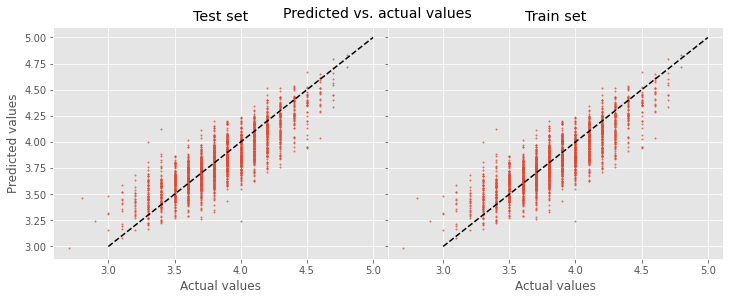

In [ ]:
def nn_model_evaluation(model, skip_epochs, X_train, X_test, y_train, y_test):

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

X = vintages_sml.X_train
#Y = vintages_sml.y_train
#x_test


skips = 3

m = baseline_model()
#model = m.fit(X, Y, epochs=40, batch_size=30, validation_split = 0.1)
model = m.fit(X, Y, epochs=60, batch_size=30)
nn_preds = m.predict(vintages_sml.X_test)
nn_preds_train = m.predict(vintages_sml.X_train)
#model = m
model_results = model.history
print(model.history)
#plt.plot(list(range(skips+1,len(model_results['loss'])+1)), model_results['loss'][skips:], label='Train')
#plt.plot(list(range(skips+1,len(model_results['val_loss'])+1)), model_results['val_loss'][skips:], label='Test', color='green')
#plt.legend()
#plt.title('Training and test loss at each epoch', fontsize=14)
#plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)


#actual_pred_plot(vintages_sml.y_test, nn_preds)
    
ax1.scatter(vintages_sml.y_test, nn_preds, s=2, alpha=0.7)
ax1.plot(list(range(3,6)), list(range(3,6)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
    
ax2.scatter(vintages_sml.y_test, nn_preds, s=2, alpha=0.7)
ax2.plot(list(range(3,6)), list(range(3,6)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')

print("Training MSE:", round(mean_squared_error(vintages_sml.y_train, nn_preds_train),4))
print("Validation MSE:", round(mean_squared_error(vintages_sml.y_test, nn_preds),4))
print("\nTraining r2:", round(r2_score(vintages_sml.y_train, nn_preds_train),4))
print("Validation r2:", round(r2_score(vintages_sml.y_test, nn_preds),4))

#nn_model_evaluation(m, skip_epochs=0, X_train=X, X_test=vintages_sml.X_test.drop(['country_name', 'winery_name', 'price', 'region', 'currency', 'median_type', 'vintage_id', 'total_flavors'], inplace=False, axis= 1) , y_train=vintages_sml.y_train, y_test=vintages_sml.y_test)

In [ ]:
#Creating summary matrix in Latex

nn_preds = m.predict(vintages_sml.X_test)
eval_df = pd.DataFrame()
eval_df['LR (Baseline)'] = evaluate_predictions(vintages_sml.y_test, lr_preds)
eval_df['RF'] = evaluate_predictions(vintages_sml.y_test, rf_preds)
eval_df['EL'] = evaluate_predictions(vintages_sml.y_test, el_preds)
eval_df['LASSO'] = evaluate_predictions(vintages_sml.y_test, l_preds)
eval_df['XGB'] = evaluate_predictions(vintages_sml.y_test, xgb_preds)  
eval_df['NN'] = evaluate_predictions(vintages_sml.y_test, nn_preds)  
eval_df.to_latex()


Bias is:  -0.0006308963707898808
Percentage of extreme observations is:  10.532994923857867
R2:  0.6330976283829777
MSE:  0.03530336621332255
Bias is:  -0.0036252115059221936
Percentage of extreme observations is:  2.284263959390863
R2:  0.8502336514628777
MSE:  0.01441052622673435
Bias is:  0.0051856064909445955
Percentage of extreme observations is:  34.390862944162436
R2:  -0.0002794689194816069
MSE:  0.09624694506960747
Bias is:  -0.0008645712244759249
Percentage of extreme observations is:  11.125211505922165
R2:  0.6311566638264945
MSE:  0.035490125928836554
Bias is:  0.00014169165729067612
Percentage of extreme observations is:  2.030456852791878
R2:  0.8528488457998041
MSE:  0.014158892084963544
Bias is:  -0.026292808648898484
Percentage of extreme observations is:  7.741116751269035
R2:  0.7020053038414548
MSE:  0.028673065921454577


'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  LR (Baseline) &        RF &         EL &      LASSO &       XGB &        NN \\\\\n\\midrule\n0 &       0.035303 &  0.014411 &   0.096247 &   0.035490 &  0.014159 &  0.028673 \\\\\n1 &       0.633098 &  0.850234 &  -0.000279 &   0.631157 &  0.852849 &  0.702005 \\\\\n2 &      10.532995 &  2.284264 &  34.390863 &  11.125212 &  2.030457 &  7.741117 \\\\\n3 &      -0.000631 & -0.003625 &   0.005186 &  -0.000865 &  0.000142 & -0.026293 \\\\\n\\bottomrule\n\\end{tabular}\n'